In [1]:
import sys
sys.path.insert(1, '..')

In [2]:
import os    
import copy
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR

from model import EfficientNet_B0
# from efficientnet_pytorch import EfficientNet

%load_ext autoreload
%autoreload 2

In [3]:
os.listdir('../data')

['cifar-10-batches-py', 'cifar-10-python.tar.gz']

In [4]:
batch = 256

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train_cifar(classifier, optimizer, scheduler, trainloader, testloader, name, epochs=100, print_freq=1, device=None):
    # save model
    best_epoch = 0
    best_loss = 0
    best_weights = copy.deepcopy(classifier.state_dict())
    
    save_dir = '../saved_models/' + name + '/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    train_losses = []
    test_losses = []
    test_acc = []
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        #training
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*len(inputs)
        running_loss = running_loss/50000
        
        #testing
        correct = 0
        total = 0
        test_loss = 0
        for data in testloader:
            with torch.no_grad():
                images, labels = data[0].to(device), data[1].to(device)
                outputs = classifier(images)
                test_loss += loss.item()*len(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = test_loss/10000
        
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        test_acc.append(correct/total)
        #test every 'print_freq' epochs
        if epoch % print_freq == 0:
            print(f'epoch: {epoch+1}/{epochs}, train loss: {train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}, test acc: {correct/total:.4f}')
    
        acc = correct/total
        if best_loss < acc:
            best_loss = acc
            best_weights = copy.deepcopy(classifier.state_dict())
            best_epoch = epoch
        # update scheduler
#         scheduler.step()
        
    torch.save(best_weights, os.path.join(save_dir, 'best.pth'))
    print('best epoch: {}'.format(best_epoch))
    
    classifier.load_state_dict(best_weights)
    
    return train_losses, test_losses, test_acc, classifier

In [6]:
def plot_history(train_losses,test_losses,test_acc,saveto):
    # Plot the loss function and train / validation accuracies
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses,label='train')
    plt.plot(test_losses,label='test')
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(test_acc, label='train')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.savefig(saveto)
    plt.show()

# EfficientNet-B0

epoch: 1/100, train loss: 2.4666, test loss: 2.0287, test acc: 0.2448
epoch: 2/100, train loss: 1.8654, test loss: 1.7289, test acc: 0.3604
epoch: 3/100, train loss: 1.6540, test loss: 1.6046, test acc: 0.4011
epoch: 4/100, train loss: 1.5368, test loss: 1.5149, test acc: 0.4382
epoch: 5/100, train loss: 1.4480, test loss: 1.4671, test acc: 0.4587
epoch: 6/100, train loss: 1.3772, test loss: 1.4200, test acc: 0.4747
epoch: 7/100, train loss: 1.3158, test loss: 1.3943, test acc: 0.4903
epoch: 8/100, train loss: 1.2675, test loss: 1.3638, test acc: 0.5080
epoch: 9/100, train loss: 1.2163, test loss: 1.3443, test acc: 0.5130
epoch: 10/100, train loss: 1.1702, test loss: 1.3347, test acc: 0.5199
epoch: 11/100, train loss: 1.1271, test loss: 1.3347, test acc: 0.5284
epoch: 12/100, train loss: 1.0870, test loss: 1.3125, test acc: 0.5356
epoch: 13/100, train loss: 1.0471, test loss: 1.3129, test acc: 0.5392
epoch: 14/100, train loss: 1.0071, test loss: 1.3159, test acc: 0.5311
epoch: 15/100, 

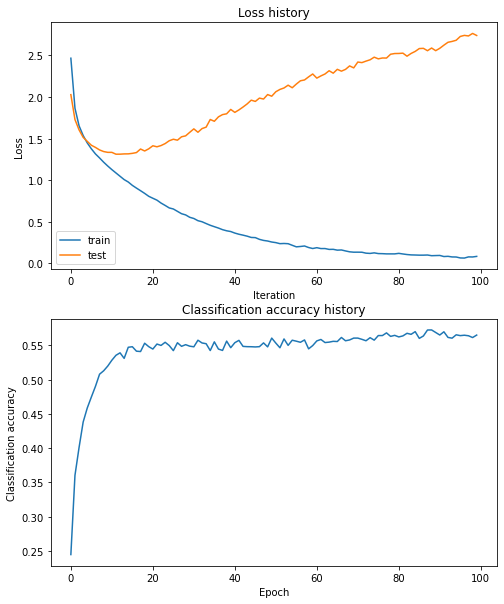

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier = EfficientNet_B0().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
train_losses, test_losses, test_acc, classifier = train_cifar(classifier, optimizer, scheduler, trainloader, testloader,
                                                    'EfficientNet-B0', epochs=100, print_freq=1)
# write losses to CSV file
file_path = '../save_loss/EfficientNet_B0_loss' + '.csv'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
solution_rows = [('train_losses', 'test_losses', 'test_acc')] + [(y, test_losses[i], test_acc[i]) for (i, y) in enumerate(train_losses)]
with open(file_path, 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(solution_rows)
        
plot_history(train_losses, test_losses, test_acc, saveto='../save_plot/EfficientNet-B0.png')



# ResNet-18

epoch: 1/100, train loss: 1.7991, test loss: 1.5222, test acc: 0.4386
epoch: 2/100, train loss: 1.4216, test loss: 1.3656, test acc: 0.5026
epoch: 3/100, train loss: 1.2778, test loss: 1.2827, test acc: 0.5349
epoch: 4/100, train loss: 1.1740, test loss: 1.2265, test acc: 0.5567
epoch: 5/100, train loss: 1.0879, test loss: 1.1648, test acc: 0.5832
epoch: 6/100, train loss: 1.0149, test loss: 1.1566, test acc: 0.5911
epoch: 7/100, train loss: 0.9455, test loss: 1.1231, test acc: 0.6032
epoch: 8/100, train loss: 0.8804, test loss: 1.1092, test acc: 0.6100
epoch: 9/100, train loss: 0.8203, test loss: 1.0928, test acc: 0.6176
epoch: 10/100, train loss: 0.7576, test loss: 1.1193, test acc: 0.6077
epoch: 11/100, train loss: 0.7018, test loss: 1.0911, test acc: 0.6276
epoch: 12/100, train loss: 0.6441, test loss: 1.1138, test acc: 0.6226
epoch: 13/100, train loss: 0.5940, test loss: 1.1294, test acc: 0.6186
epoch: 14/100, train loss: 0.5380, test loss: 1.1322, test acc: 0.6288
epoch: 15/100, 

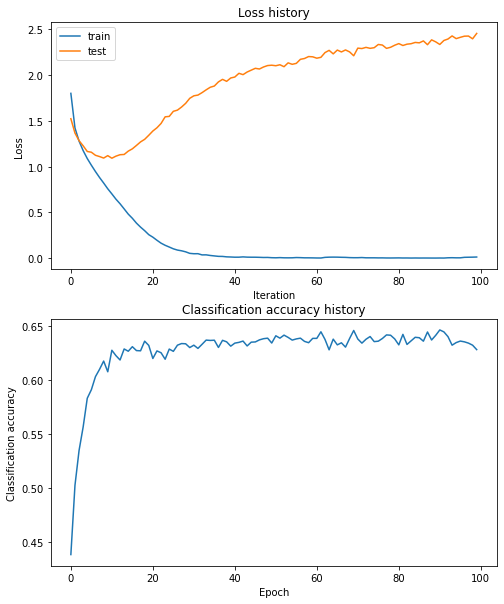

In [8]:
classifier = models.resnet18(pretrained=False)
classifier.fc = nn.Linear(512, len(classes))
classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

train_losses, test_losses, test_acc, classifier = train_cifar(classifier, optimizer, scheduler, trainloader, testloader,
                                                   'ResNet-18', epochs=100, print_freq=1)
# write losses to CSV file
file_path = '../save_loss/ResNet18_loss' + '.csv'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
solution_rows = [('train_losses', 'test_losses', 'test_acc')] + [(y, test_losses[i], test_acc[i]) for (i, y) in enumerate(train_losses)]
with open(file_path, 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(solution_rows)

plot_history(train_losses, test_losses, test_acc, saveto='../save_plot/ResNet-18.png')